In [2]:
import nltk

from collections import Counter

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score

import pickle
import torch
import re

### Passo 1

- Leitura do arquivo;
- Análise das características da base;
- Alteração nos textos para formato propício de input.

A base de dados possui mais de 6 milhões de avaliações, entretanto somente uma parte dessas será trabalhada aqui na apresentação das características. 

In [2]:
read_json = False
parquet_path = 'D:/Documentos/Estudos/Projeto-NLP/dataset/yelp_academic_dataset_review.parquet'
json_path = 'D:/Documentos/Estudos/Projeto-NLP/dataset/yelp_academic_dataset_review.json'
glove_path = 'D:/Documentos/Estudos/Projeto-NLP/dataset/glove.twitter.27B.100d.txt'

if read_json:

    df = pd.DataFrame()
    for chunk in pd.read_json(json_path, lines= True, chunksize= 100000):
        df = pd.concat([df, chunk[['stars', 'text']]])

else:
    # Ler uma fração do código
    df = next(pd.read_json(json_path, lines= True, chunksize= 100000, ))[['stars', 'text']]

In [3]:
print(f'Tamanho do dataset: {df.shape[0]}, {df.shape[1]}')
print(f'Colunas: {df.columns.values}')

Tamanho do dataset: 100000, 2
Colunas: ['stars' 'text']


In [4]:
df.head()

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
1,5,I've taken a lot of spin classes over the year...
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...


In [5]:
def plot_graph(data):

    plt.figure(figsize=(8,4))
    ax= sns.barplot(x= data.index, y= data.values, alpha=0.8)
    plt.title("Distribuição das Avaliações")
    plt.ylabel('Qnt de reviews', fontsize=12)
    plt.xlabel('Estrelas', fontsize=12)

    rects = ax.patches
    labels = data.values

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, label, ha='center', va='bottom')

    # Ajusta os rótulos do eixo x para ir de 1 a 5
    plt.xticks(ticks=data.index - 1, labels=data.index)

    plt.show()

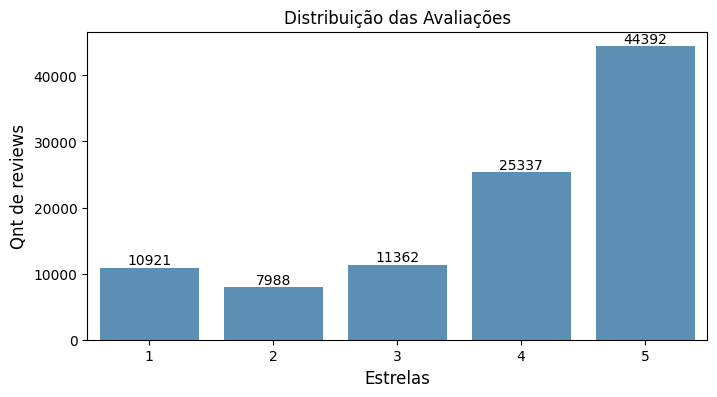

In [6]:
plot_graph(df['stars'].value_counts().sort_index())

In [8]:
print('Amostra de um texto:\n')
print('.\n'.join((df['text'].sample(1, random_state= 42).values[0]).split('.')))

Amostra de um texto:

I love elevation burger but they need to clean the restaurant better.
 There's little flys everywhere


Como pode ser observado, os textos não possuem uma formatação boa para servir de input para o modelo. 
Para isso foi feita a função `clean_text()`, responsável por remover todos os caracteres que não apresentam muito significado, separar todas as palavras por um único espaçamento e deixar as palavras em lower case. 

In [9]:
tokenizer = nltk.tokenize.WordPunctTokenizer()


def clean_text(text):
    text = re.sub(r"[^\w\s']", '', str(text))
    return ' '.join(tokenizer.tokenize(str(text))).lower()



df['text'] = df['text'].apply(clean_text)

In [10]:
print(f'Amostra do mesmo texto após a formatação:\n\n{df['text'].sample(1, random_state= 42).values[0]}')

Amostra do mesmo texto após a formatação:

i love elevation burger but they need to clean the restaurant better there ' s little flys everywhere


### Passo 2
- Separação entre conunto de treinamento, validação e teste;
- Criação do vocabulário a partir do conjunto de treinamento;
- Codificação do vocabulário que o formato seja adequado para o modelo. 

In [11]:
data_val, data_test = train_test_split(df, test_size= 0.1, random_state= 42)
data_train, data_val = train_test_split(data_val, test_size= 2/9, random_state= 42)

print(data_val.shape, data_test.shape, data_train.shape)


(20000, 2) (10000, 2) (70000, 2)


In [12]:
data_train.head()

,stars,text
4696,5,came here on a saturday afternoon with a group...
47133,3,this place is definitely a dive bar that cater...
22299,5,kajun ' s pub is a dive bar simply for those w...
16063,4,i looked here on yelp then went downtown looki...
7004,5,stopped here today been wanting to get in here...


Criação da variável `tokens_count`, uma lista de tuplas que contem a palavra do vocabulário e sua frequência.

In [13]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

all_text = ' '.join(data_train['text'].values)


all_tokens = tokenizer.tokenize(all_text)
tokens_count = Counter(all_tokens)

In [16]:
toks, freq =  zip(*tokens_count.most_common(15))

Text(0, 0.5, 'Frequência')

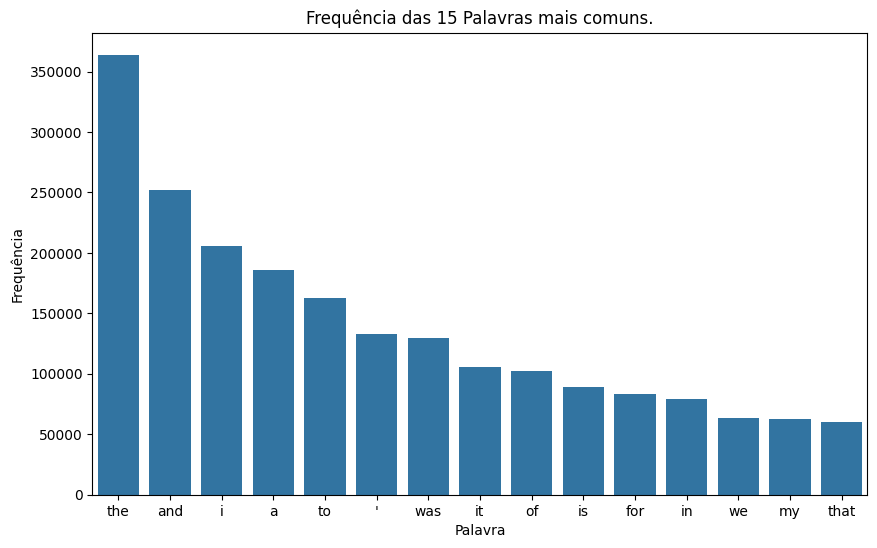

In [18]:
plt.figure(figsize= (10,6))
sns.barplot(x= list(toks), y= list(freq))
plt.title(f'Frequência das {len(toks)} Palavras mais comuns.')
plt.xlabel('Palavra')
plt.ylabel('Frequência')

In [23]:
print(f'O vocabulário possui {len(tokens_count)} palavras')

O vocabulário possui 81768 palavras


Também é uma boa prática remover palavras que se apresentam com pouca frequência. 

Neste caso, todas as palavras que se repetiram menos que 10 vezes foram retiradas do vocabulário. 

In [28]:
# Ordena os tokens e filtra palavras pouco frequentes.
tokens =  sorted(t for t, c in tokens_count.items() if c >= 10)

# UNK é um token utilizado para palavras na validação e teste que não estão presente no vocabulário.
# PAD vem de padding, utilizado para garantir que todas as frases possuam o mesmo tamanho.                  
UNK, PAD = "UNK", "PAD"

tokens = [UNK, PAD] + tokens

In [43]:
print(f'10 Primeiros tokens:\n [{', '.join(tokens[:10])}]\n\n10 tokens no meio do vocabulário:\n [{', '.join(tokens[5000:5010])}]\n\nÚltimos 10 tokens:\n [{', '.join(tokens[-10:])}]')

10 Primeiros tokens:
 [UNK, PAD, ', 0, 05, 075, 1, 10, 100, 1000]

10 tokens no meio do vocabulário:
 [fighting, fights, figs, figure, figured, figures, figuring, fil, file, filed]

Últimos 10 tokens:
 [zombies, zone, zoo, zoom, zorba, zu, zucchini, zumba, à, étouffée]


In [46]:
print(f'Quantidade de tokens após a filtragem: {len(tokens)}')

Quantidade de tokens após a filtragem: 14281


Para garantir a codificação e decodificação da frase, também é necessário que haja uma lista com os tokens e seus ids, conforme realizado na celula a seguir.

In [49]:
token_to_id = {k: i for i, k in enumerate(tokens)}

In [50]:
def as_matrix(sequences, max_len=None, UNK_IX= 0, PAD_IX= 1):

    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [69]:
for i, code in enumerate(as_matrix(df['text'][:2])):
    print(f'Frase original: \n{df.iloc[i]['text'][:52]}')
    print()
    print(f'Frase codificada: \n{code[:10]}')
    print()
    print(20*'-')


Frase original: 
if you decide to eat here just be aware it is going 

Frase codificada: 
[ 6460 14217  3625 12958  4338  6144  7010  1365  1168  6826]

--------------------
Frase original: 
i ' ve taken a lot of spin classes over the years an

Frase codificada: 
[ 6431     2 13572 12569   375  7601  8770 11950  2673  8970]

--------------------


Com os tokens propriamente codificados, eles já podem ser inseridos como inputs para o modelo proposto. 

### Passo 3

- Carregamento dos pesos pré-treinados;
- Word Embedding.

Até o momento, as palavras estão sendo representadas por indexes, que quanto passado para vetores podem ser interpretadas como one-hot vectors. Entretanto isso não é uma boa prática, quando nós estamos interpretando um texto, entendemos o que se passa em seu contexto e também somos capazes de substituir palavras por outras com significados similares. 

A forma de representar isso para uma Rede Neural é através do `Word Embedding`. A palavra é transformada em um vetor de tamanho N e todos os seus componentes são responsáveis por atribuir um contexto.

O word embedding entrará como um pré-treinamento, visto que este conhecimento é prévio. Utilizei uma versão do GloVe, treinado sobre 27 bilhões de palavras no Twitter e de dimensão 100. 

In [179]:

def load_glove_embeddings(glove_path, chosen_words, seed= 42):
    embeddings_index = {}
    words_vocab = []

    np.random.seed(seed)
    with open(glove_path, 'r', encoding= 'utf-8') as file:
        for line in file:
            
            values = line.split()
            # Primeiro valor é referente ao token
            word = values[0]
            # Próximos valores são referentes às entradas do vetor
            coefs = np.asarray(values[1:])
                
            if word in chosen_words:
                embeddings_index[word] = coefs
                words_vocab.append(word)
    
    return words_vocab, embeddings_index

def reduce_to_3d(embeddings_index):
    word_vectors = np.array(list(embeddings_index.values()))
    pca = PCA(n_components= 3)

    word_vectors_3d = pca.fit_transform(word_vectors)
    explained_variance = np.sum(pca.explained_variance_ratio_) * 100

    print(f'A variância mantida pelos 3 primeiros componentes foi de: {explained_variance:.2f}')

    return word_vectors_3d

def normilize_vectors(vectors):
    norm = np.linalg.norm(vectors, axis= 1, keepdims= True)
    return vectors / norm

def plot_3d_graph(words, word_vectors_3d):
    fig = plt.figure(figsize= (10, 8))
    ax = fig.add_subplot(111, projection= '3d')

    origin = np.zeros((3,))

    word_vectors_3d_norm = normilize_vectors(word_vectors_3d)
    
    for i, word in enumerate(words):
        ax.quiver(origin[0], origin[1], origin[2], word_vectors_3d_norm[i, 0], word_vectors_3d_norm[i, 1], word_vectors_3d_norm[i, 2], arrow_length_ratio=0.1, linewidth=0.5)
        ax.text(word_vectors_3d_norm[i, 0] , word_vectors_3d_norm[i, 1] , word_vectors_3d_norm[i, 2] , word, fontsize= 9)
    
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    plt.title('Representação das palavras selecionadas no Espaço reduzido')

    max_range = np.max(np.abs(word_vectors_3d_norm)) * 0.9
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    plt.show()


In [171]:
random_words, embeddings_index = load_glove_embeddings(glove_path, ['rei', 'rainha', 'homem', 'mulher', 'bom', 'ótimo', 'excelente', 'ruim', 'lua', 'cachorro', 'céu', 'nuvem', 'sol', 'comida', 'bebida'])


In [172]:
word_vectors_3d = reduce_to_3d(embeddings_index)


A variância mantida pelos 3 primeiros componentes foi de: 50.01


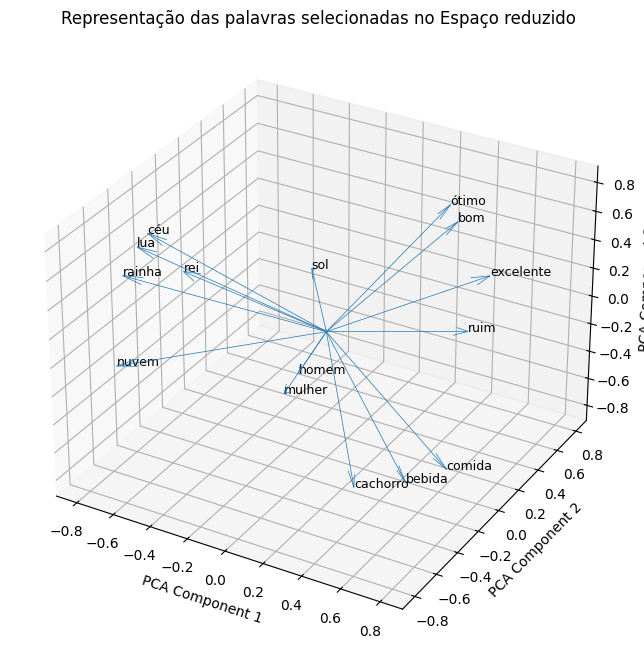

In [180]:
plot_3d_graph(random_words, word_vectors_3d)

Já que houve uma redução na dimensionalidade do vetor através do PCA, parte da informação foi pedida. Entretanto já é possível reparar que alguns vetores de palavras semelhante já "apontam" para o mesmo local, como por exemplo:
- Homem e mulher;
- Bom e ótimo;
- Lua e céu;
- Rainha e rei;

### Passo 4

- Análise do dataset de teste;
- Representação da Perda no set de validação através das Épocas;
- Aplicação de métricas de avaliação dos resultados:
    - Precisão;
    - Recall;
    - F1-Score.


In [16]:
with open('D:/Documentos/Estudos/Projeto-NLP/dataset/test_set/test-set-index.txt', 'rb') as file:
    text_index = pickle.loads(file.read())

print(f'Quantidade de amostras utilizadas para o teste: {len(text_index)}')

Quantidade de amostras utilizadas para o teste: 699028


Na fase de treinamento, devemos garantir que o modelo esteja "Aprendendo" a resolver a questão proposta. Entretanto, medidas devem ser tomadas para que o modelo não entre em Overfitting, ou seja, "aprenda" a solucionar a base de treino e não o problema geral. 

O set de validação serve para acompanharmos a performance do modelo em dados que ainda não foram vistos naquela época do treinamento. A métrica utilizada nesse projeto foi a `CrossEntropyLoss`. Dessa forma, caso essa métrica continue diminuindo ao longo das Épocas, o modelo está convergindo para bons resultados e será capaz de generalizar para dados ainda não vistos. 

Também existem medidas que podem ser tomadas para evitar o Overfitting: 
- Dropout: Desativa uma fração dos neurônios (Por Época), realizando um ensemble de redes ao longo das épocas.
- Early Stopping: O treinamento deve ser para caso a diferença de uma Época para a anterior seja menor que um limiar (Hiperparâmetro) por n vezes seguidas (Hiperpârametro) 

In [3]:
# Função responsável por plotar os valores da CrossEntropyLoss ao longo das épocas.
def plot_loss_by_epoch(sequence):
    epochs = list(range(1, len(sequence) + 1))
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, sequence, marker='o', color='orange')
    plt.title(f'Validation Loss para {len(epochs)} Épocas')
    plt.xlabel('Epochs')
    plt.ylabel('Val Loss')

    plt.grid(False)
    plt.show()
    

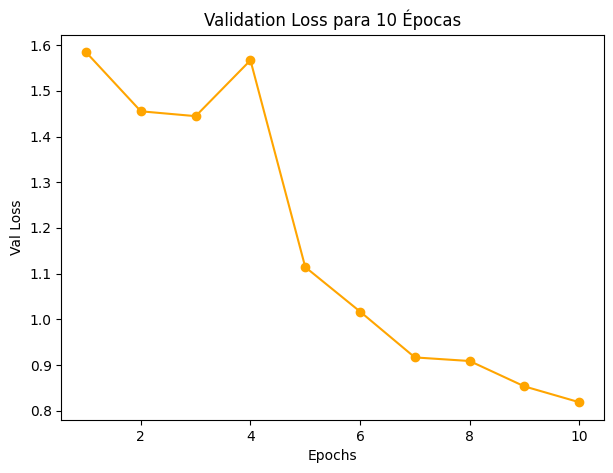

In [48]:
with open('D:/Documentos/Estudos/Projeto-NLP/values/val_values/val_values_10epochV2.txt', 'rb') as file:
    plot_loss_by_epoch(pickle.loads(file.read()))

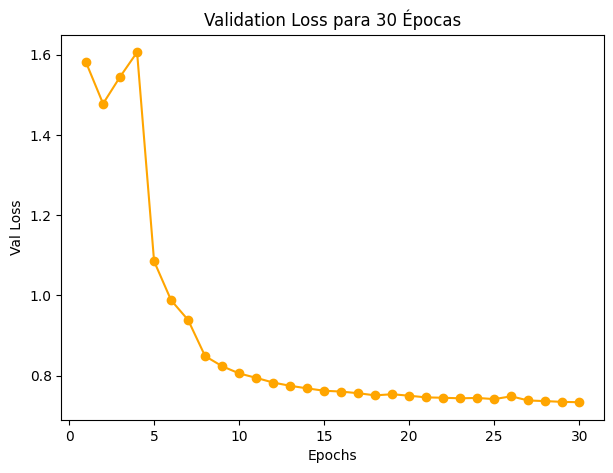

In [49]:
with open('D:/Documentos/Estudos/Projeto-NLP/values/val_values/val_values_30epoch.txt', 'rb') as file:
    plot_loss_by_epoch(pickle.loads(file.read()))

In [4]:
# Carregando as previsões e os labels originais para avaliar as métricas do modelo proposto. 
labels = torch.load('D:/Documentos/Estudos/Projeto-NLP/values/test_values/all-labels.pt').to('cpu')
preds = torch.load('D:/Documentos/Estudos/Projeto-NLP/values/test_values/all-preds.pt').to('cpu')

Já que estamos lidando com um problema de multi-classes e desbalanceado, usaremos as três métricas citadas anteriormente:
<div style="text-align: center;">

 
$$Precisão = \frac{VP}{VP + FP} \hspace{20mm}

Recall = \frac{VP}{VP + FN} \hspace{20mm}

Acurácia = 2 * \frac{Precisão * Recall}{Precisão + Recall}$$

**VP**: Verdadeiro Positivo  \
**FN**: Falso Negativo

</div>

In [8]:
f1 = f1_score(labels, preds, average= 'weighted')
precision = precision_score(labels, preds, average= 'weighted')
recall = recall_score(labels, preds, average= 'weighted')

print(f'O modelo proposto obteve as seguinte métricas:\n\n- Precisão: {precision*100:.2f}%\n- Recall: {recall*100:.2f}%\n- F1-Score: {f1*100:.2f}%')

O modelo proposto obteve as seguinte métricas:

- Precisão: 73.97%
- Recall: 70.86%
- F1-Score: 71.93%


### Conclusão

O problema proposto consistia em aplicar um modelo de Deep Learning para classificar reviews do Yelp. O modelo foi uma LSTM vanilla, combinada com pesos pré-treinados para a representação de tokens. Além disso, foram aplicadas técnicas para prevenir o overfitting e melhorar a capacidade de generalização do modelo. 

O resultado deste modelo ficou na faixa dos 72%, o que é algo bastante positivo, visto que a análise de texto de reviews de restaurantes é bastante subjetiva, sendo difícil até mesmo para nós humanos as vezes.

Mesmo que com este resultado positivo, existem maneiras de melhorar ainda mais a classificação destes textos, como por exemplo:
- Tokenização de Sub-words, já que estamariamos trabalhando com partes de palavras, o número de "Unknown" tokens tenderia a diminuir.
- Melhoria no modelo empregado, existem diversas maneiras de melhorar o modelo proposto:
    - Aumento das Camadas do Modelo;
    - Aplicação da LSTM Bidirecional;
    - Aplicação do Transformer Encoder.